In [ ]:
# todo
# powerpoint presentation according to the size of your project and pres. skills
# (time yourself properly)
# research style presentation, background, related work, math hardcore, examples, conclusions, references
# live demonstration
# may 2, may 9 (most likely may 9)

# Imports

In [ ]:
!pip install -q kaggle  # kaggle api 
!pip install -q albumentations==0.4.6 # something is wrong with the default version that comes with colab
!pip install -q torchinfo 

import os
import cv2
import torch  
import time
import random
import numpy as np   
import pandas as pd 
import matplotlib.pyplot as plt
import mpl_toolkits
import albumentations as A

from glob import glob
from skimage import io
from torchinfo import summary
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from google.colab import drive, files 
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

if not os.path.exists('kaggle.json'):
  drive.mount('/content/drive')
  files.upload()

if not os.path.exists('lgg-mri-segmentation/'):
  !ls -lha kaggle.json
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
  !unzip -q lgg-mri-segmentation.zip

#Configuing pandas options so output cells aren't truncated
pd.options.display.max_seq_items = 5000
pd.options.display.max_rows = 5000
pd.set_option('display.max_columns', 50)

# Checking if GPU is available
print(f"Pytorch version: {torch.__version__} ")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cpu":
    print("GPU not found. Using CPU instead.")
print(torch.version.cuda)

Pytorch version: 2.0.0+cu118 
11.8


# Loading data from Kaggle API

In [ ]:
data_dir = 'lgg-mri-segmentation/kaggle_3m'
def create_dataframe(data_dir):
  image_paths = []
  mask_paths = glob(f'{data_dir}/*/*_mask*')
  for i in mask_paths:
    image_paths.append(i.replace('_mask', ''))
  df = pd.DataFrame(data={'image_paths': image_paths, 'mask_paths': mask_paths})
  return df

def positive_negative_diagnosis(mask_path):
    value = np.max(io.imread(mask_path))
    if value > 0 : return 1
    else: return 0


all_df = create_dataframe(data_dir)
all_df['diagnosis'] = all_df['mask_paths'].apply(lambda x: positive_negative_diagnosis(x))
all_df.head()

,image_paths,mask_paths,diagnosis
0,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,0
1,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,0
2,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,0
3,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,0
4,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19...,0


## Visualize data 

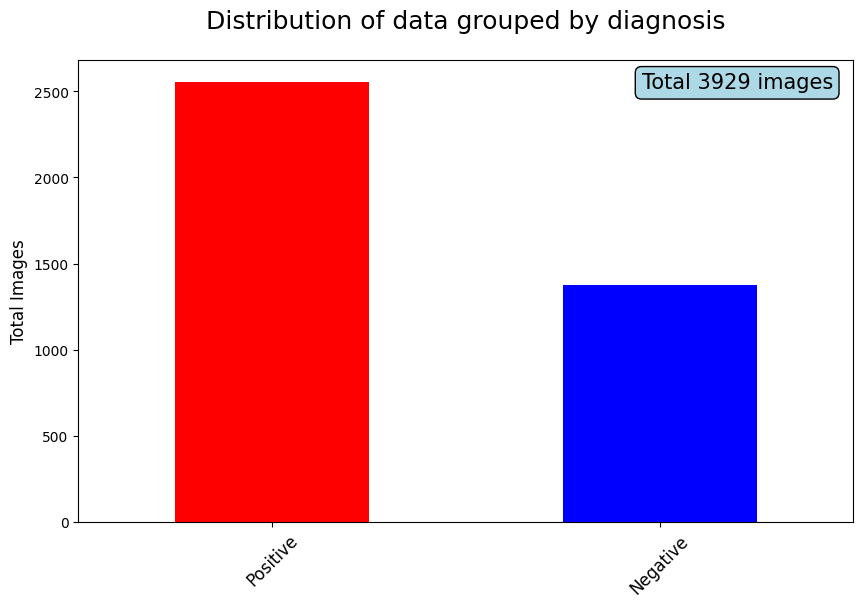

In [ ]:
# Plot
ax = all_df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["red", "blue"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(all_df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(all_df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

## setting train/val/test

In [ ]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(all_df, stratify=all_df.diagnosis, test_size=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15, random_state=42)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 3) 
Val: (393, 3) 
Test: (531, 3)


# Helper functions 

In [ ]:
# Get the standard deviation of the images
# def mean_std(loader):
#   images, lebels = next(iter(loader))
#   # shape of images = [b,c,w,h]
#   mean, std = images.mean([0,2,3]), images.std([0,2,3])
#   return mean, std

def mean_std(loader, df):
  count = len(df) * 256 * 256
  psum    = torch.tensor([0.0, 0.0, 0.0])
  psum_sq = torch.tensor([0.0, 0.0, 0.0])
  for inputs, masks in loader:
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
  # mean and std
  total_mean = psum / count
  total_var  = (psum_sq / count) - (total_mean ** 2)
  total_std  = torch.sqrt(total_var)
  # output
  print('mean: '  + str(total_mean))
  print('std:  '  + str(total_std))

# reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# setting up `DataLoader`

In [ ]:
class BrainMRIDataset(torch.utils.data.Dataset):
  """
  df (pandas.Dataframe): Dataframe containing image / masks paths
  transforms (albumentations.Compose): data transformation pipeline
  """
  def __init__(self, df, transforms=None):
    self.image_paths = df['image_paths'].tolist()
    self.mask_paths = df['mask_paths'].tolist()
    self.transforms = transforms
  
  def __getitem__(self, i):
    image = io.imread(self.image_paths[i])
    mask = io.imread(self.mask_paths[i])
    #image = image / 255
    #mask = mask / 255
    if self.transforms:
      transform = self.transforms(image=image, mask=mask)
      image = transform['image']
      mask = transform['mask']
    
    return image, mask.unsqueeze(0)
  
  def __len__(self):
    return len(self.image_paths)

## visualize image and masks

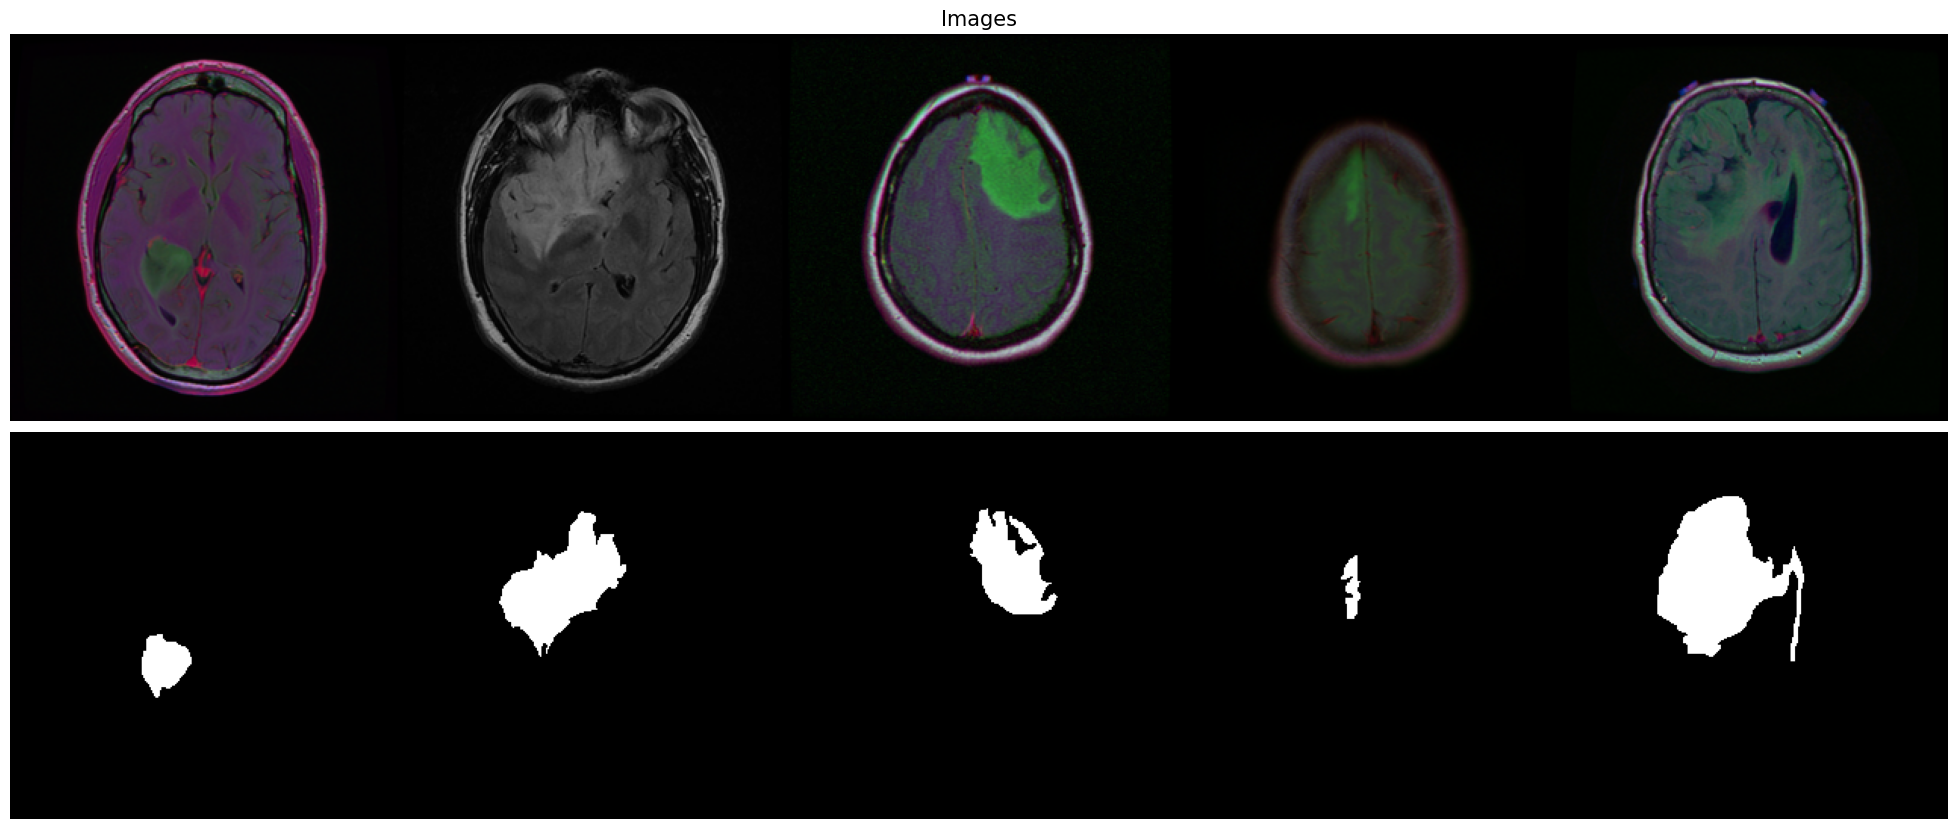

In [ ]:
sample_df = all_df[all_df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data[0])
    #print(data[1])
    img = cv2.resize(cv2.imread(data[0]), (256, 256))
    mask = cv2.resize(cv2.imread(data[1]), (256, 256))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

# Augmentations

In [ ]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

def get_training_augmentation():
  return A.Compose([
      A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
      A.ShiftScaleRotate(
          shift_limit=0.0625, 
          scale_limit=0, 
          rotate_limit=15, 
          p=0.1
      ),
      A.OneOf([
        A.ElasticTransform(p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
      A.Normalize(mean = (0.0921, 0.0834, 0.0877),
                  std = (0.1356, 0.1237, 0.1292)),
      ToTensorV2(),
  ])

def get_validation_augmentation():
    return A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(mean = (0.0921, 0.0834, 0.0877),
                    std = (0.1356, 0.1237, 0.1292)),
        ToTensorV2(),
    ])

## visualize augmentations

In [ ]:
train_dataset = BrainMRIDataset(df=train_df, transforms=get_training_augmentation())
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2, shuffle=True)

torch.Size([15, 3, 256, 256]) torch.Size([15, 1, 256, 256])


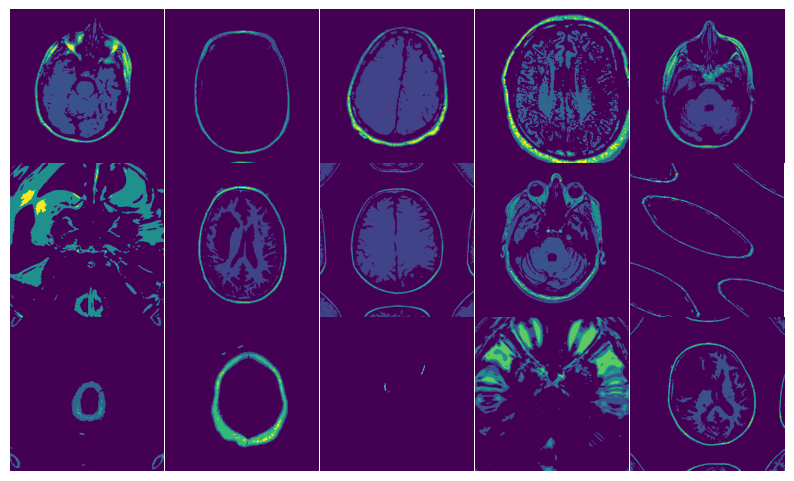

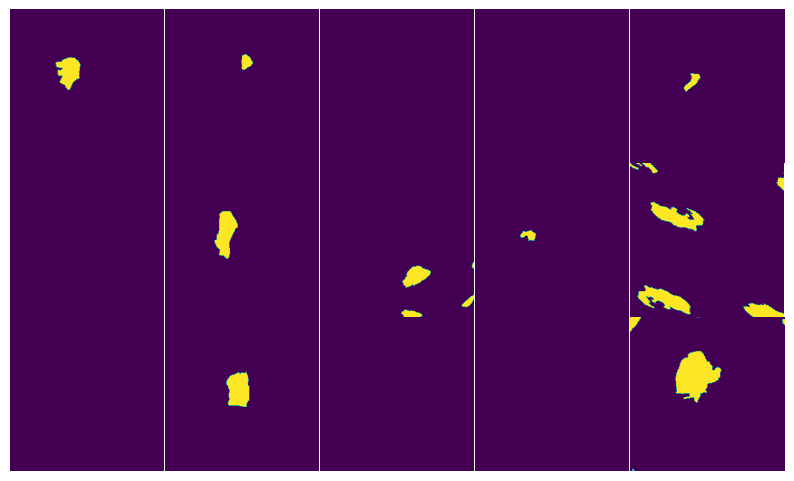

In [ ]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        img = inputs[idx].numpy().astype(np.float32)
        img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img.astype('uint8')); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

# model_0: UNet from scratch

<img src="https://pytorch.org/assets/images/unet_brain_mri.png" alt="alt" width="50%"/>

In [ ]:
import torch.nn as nn
import torchvision.transforms.functional as TF


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=(64, 128, 256, 512),
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

In [ ]:
example_model = UNet(in_channels=3, out_channels=1)
summary(example_model, input_size=[16, 3, 256, 256]) # do a test pass through of an example input size 

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 1, 256, 256]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [16, 64, 256, 256]        --
│    │    └─Sequential: 3-1              [16, 64, 256, 256]        38,848
├─MaxPool2d: 1-2                         [16, 64, 128, 128]        --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [16, 128, 128, 128]       --
│    │    └─Sequential: 3-2              [16, 128, 128, 128]       221,696
├─MaxPool2d: 1-4                         [16, 128, 64, 64]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [16, 256, 64, 64]         --
│    │    └─Sequential: 3-3              [16, 256, 64, 64]         885,760
├─MaxPool2d: 1-6                         [16

## dice loss and IoU

In [ ]:
import torch.nn.functional as F

def _threshold(x, threshold=None):
  if threshold is not None:
    return (x > threshold).type(x.dtype)
  else:
    return x

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc    

class IoU(nn.Module):
    def __init__(self, eps=1e-7, threshold=0.5):
        super(IoU, self).__init__()
        self.eps = eps
        self.threshold = threshold

    def forward(self, inputs, targets):
        assert inputs.size() == targets.size()
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        targets = _threshold(targets, self.threshold)
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection + self.eps
        
        IoU = (intersection + self.eps) / union
                
        return IoU

# train/val `DataLoaders`'s

In [ ]:
train_dataset = BrainMRIDataset(
    train_df, 
    transforms=get_training_augmentation(),
)

valid_dataset = BrainMRIDataset(
    val_df, 
    transforms=get_validation_augmentation(), 
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=1)

# set hyperparams

In [ ]:
# Initialize model
model = UNet().to(DEVICE)

# Set number of epochs
EPOCHS = 50

# Define the loss function
criterion = DiceLoss()

# Define metric 
metric = IoU()

# Define learning rate
learning_rate = 1e-3

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Flag to load best model
LOAD_MODEL = False
if LOAD_MODEL:
  print('Using previous best model...')
  try: model = torch.load('./best_model.pt', map_location=DEVICE)
  except FileNotFoundError as e: print(e)

# Training

In [ ]:
%%time
train_loss = []
train_iou = []
val_loss = []
val_iou = []
best_loss = 1_000_000

for epoch in range(EPOCHS):
  model.train()
  print('Epoch {}/{}'.format(epoch+1, EPOCHS))
  start_time = time.time()
  running_train_loss = []
  running_train_iou = []
  # Training
  for image, mask in train_loader:
    image = image.to(DEVICE, dtype=torch.float)
    mask = mask.to(DEVICE, dtype=torch.float)
    pred_mask = model(image)
    loss = criterion(pred_mask, mask)
    iou = metric(pred_mask, mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_train_loss.append(loss.item())
    running_train_iou.append(iou.item())

  # Validation
  else:
    running_val_loss = []
    running_val_iou = []
    model.eval()
    with torch.no_grad():
      for image, mask in valid_loader:
        image = image.to(DEVICE, dtype=torch.float)
        mask = mask.to(DEVICE, dtype=torch.float)
        pred_mask = model(image)
        loss = criterion(pred_mask, mask)
        iou = metric(pred_mask, mask)
        running_val_loss.append(loss.item())
        running_val_iou.append(iou.item())
  
  # Check stats
  epoch_train_loss = np.mean(running_train_loss)
  epoch_train_iou = np.mean(running_train_iou) 
  print(f'Train: dice_loss {epoch_train_loss} iou_score {epoch_train_iou}'.format(epoch_train_loss))
  train_loss.append(epoch_train_loss)
  train_iou.append(epoch_train_iou)
  
  epoch_val_loss = np.mean(running_val_loss)
  epoch_val_iou = np.mean(running_train_iou)
  print(f'Valid: dice_loss {epoch_val_loss} iou_score {epoch_val_iou}')
  # print('Valid: dice_loss{}'.format(epoch_val_loss))
  # print('Validation iou score: {}'.format(epoch_val_iou))                                               
  val_loss.append(epoch_val_loss)
  val_iou.append(epoch_val_iou)

  # Saving state of best model
  if epoch_val_loss < best_loss:
    print('Saving model...')
    epoch_val_loss = best_loss
    torch.save(model.state_dict(), './best_model.pt')
  
  # Time elapsed per epoch                   
  time_elapsed = time.time() - start_time
  print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/50
Train loss: -0.6821393662310661
Train iou score: 0.03313992039964316
Validation loss: -0.7343084001541138
Validation iou score: 0.03313992039964316
Saving model...
2m 38s
Epoch 2/50
Train loss: -0.7439178577128877
Train iou score: 0.041073970746823604
Validation loss: -0.7848431301116944
Validation iou score: 0.041073970746823604
Saving model...
2m 33s
Epoch 3/50
Train loss: -0.7576612639934459
Train iou score: 0.04668364226861431
Validation loss: -0.7905743074417114
Validation iou score: 0.04668364226861431
Saving model...
2m 31s
Epoch 4/50
Train loss: -0.7592399383478976
Train iou score: 0.04773394251799588
Validation loss: -0.8264619731903076
Validation iou score: 0.04773394251799588
Saving model...
2m 32s
Epoch 5/50
Train loss: -0.7639600114619478
Train iou score: 0.052779274123245255
Validation loss: -0.8173187971115112
Validation iou score: 0.052779274123245255
Saving model...
2m 31s
Epoch 6/50
Train loss: -0.7940723274616485
Train iou score: 0.050691916017812935
Valid

# Train/Validation loss 

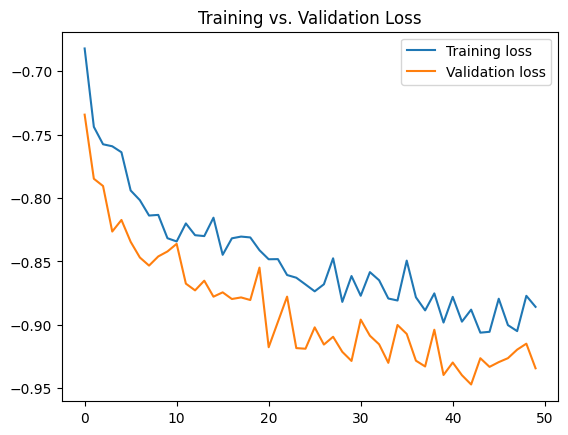

In [ ]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

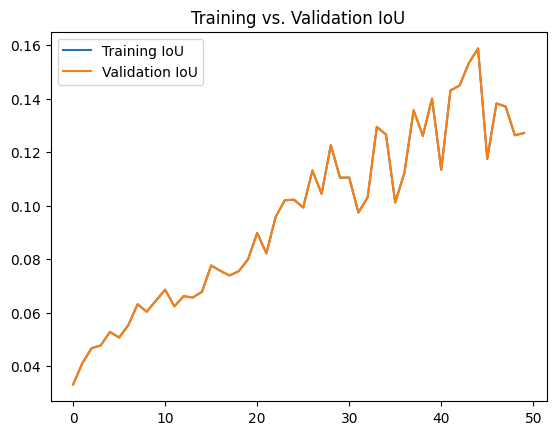

In [ ]:
plt.plot(train_iou, label='Training IoU')
plt.plot(val_iou, label='Validation IoU')
plt.legend()
plt.title('Training vs. Validation IoU')
plt.show()

# Inference

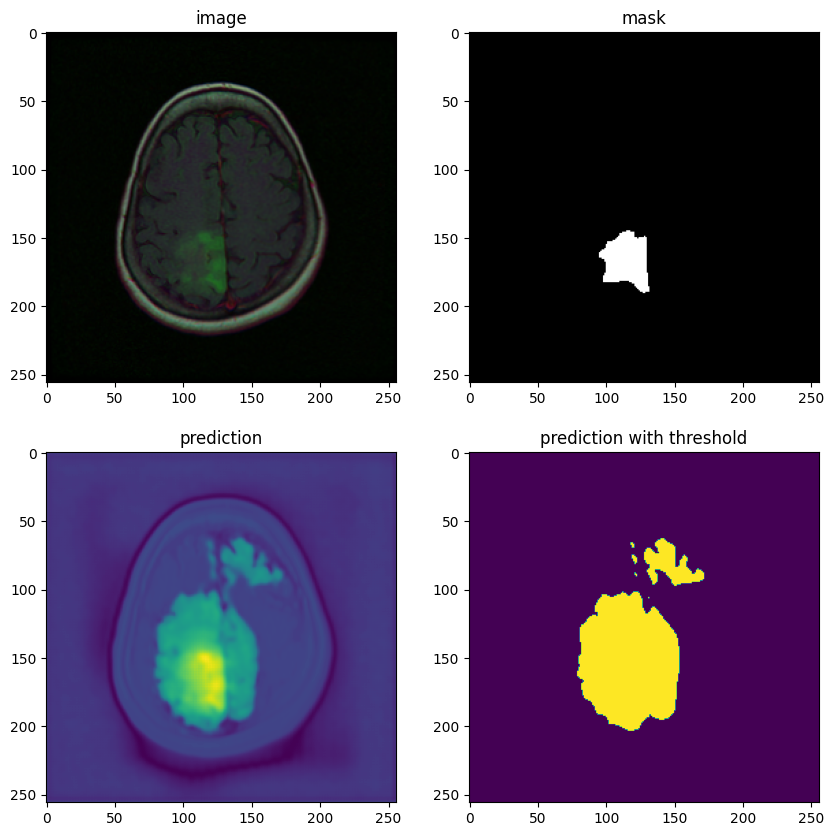

In [ ]:
# image
from torchvision import transforms

test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (256, 256))
m, s = np.mean(image, axis=(0, 1)), np.std(image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0921, 0.0834, 0.0877), std=(0.1356, 0.1237, 0.1292)),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

#mask
mask = cv2.resize(cv2.imread(test_sample[1]), (256, 256))

# pred
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

with torch.no_grad():
  pred = model(input_batch)

pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.4)] = 0.0
pred_t[np.nonzero(pred_t >= 0.4)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

## Inference with pre-trained model

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


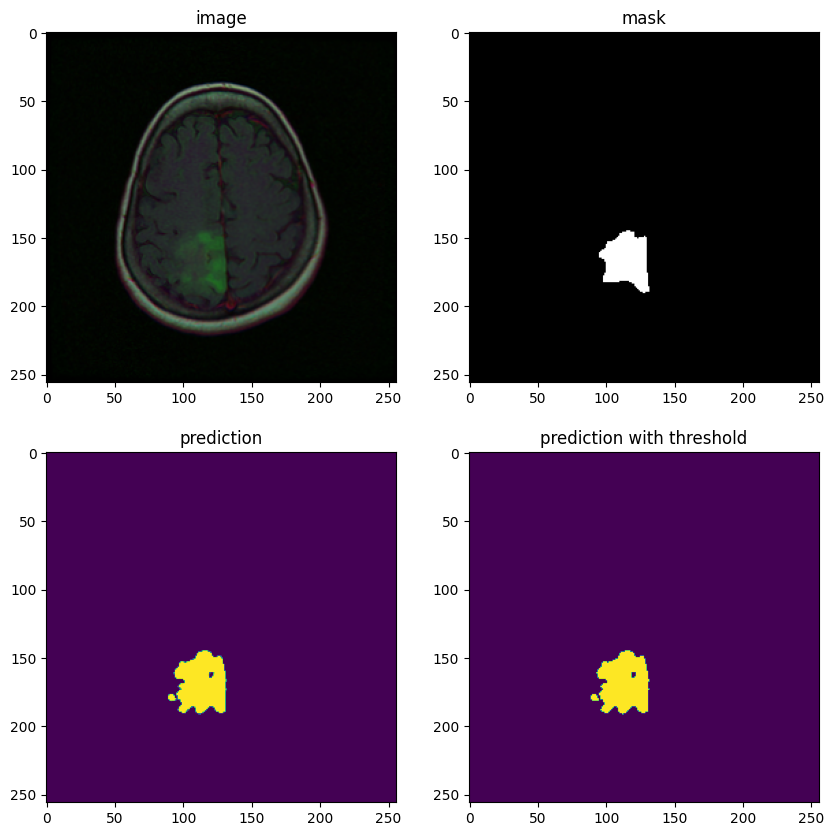

In [ ]:
pretrained_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    pretrained_model = pretrained_model.to('cuda')

with torch.no_grad():
    pred = pretrained_model(input_batch)
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.4)] = 0.0
pred_t[np.nonzero(pred_t >= 0.4)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()